In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product j.csv', parse_dates=['Month-Year'])


In [3]:
sales_j= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_j = sales_j.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_j.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,63722,238469,164221
1,2019-02-01,76987,288111,198407
2,2019-03-01,99645,372905,256800
3,2019-04-01,68529,256458,176610
4,2019-05-01,45119,168850,116279


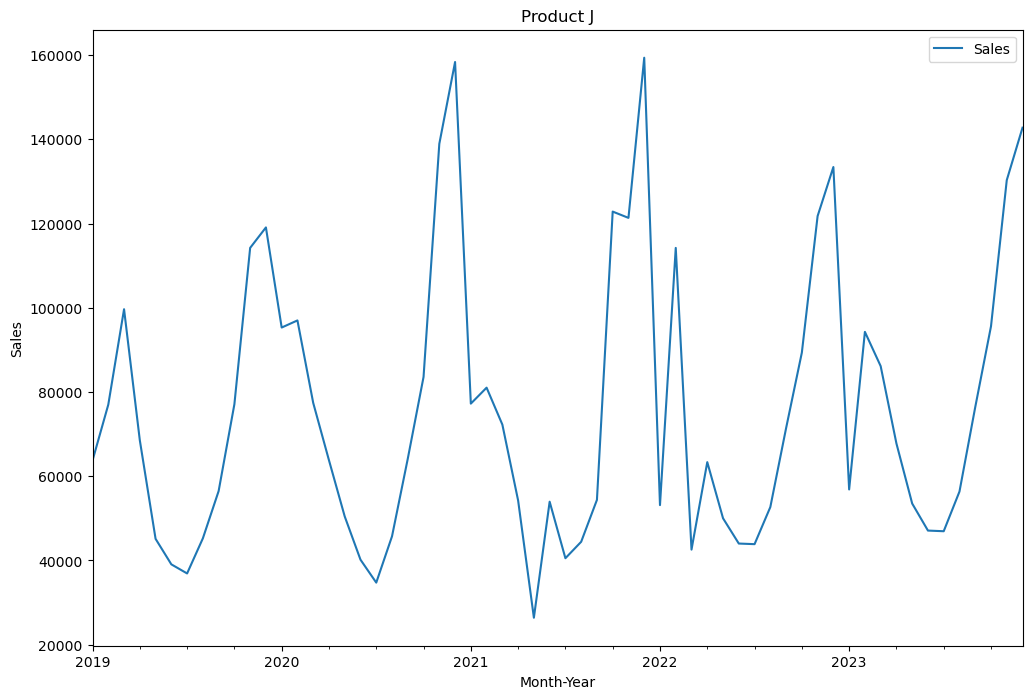

In [5]:
ax = sales_j.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product J')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_j[:54]
test=sales_j[54:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

01:03:14 - cmdstanpy - INFO - Chain [1] start processing
01:03:14 - cmdstanpy - INFO - Chain [1] done processing
01:03:16 - cmdstanpy - INFO - Chain [1] start processing
01:03:16 - cmdstanpy - INFO - Chain [1] done processing
01:03:19 - cmdstanpy - INFO - Chain [1] start processing
01:03:20 - cmdstanpy - INFO - Chain [1] done processing
01:03:22 - cmdstanpy - INFO - Chain [1] start processing
01:03:22 - cmdstanpy - INFO - Chain [1] done processing
01:03:24 - cmdstanpy - INFO - Chain [1] start processing
01:03:24 - cmdstanpy - INFO - Chain [1] done processing
01:03:28 - cmdstanpy - INFO - Chain [1] start processing
01:03:28 - cmdstanpy - INFO - Chain [1] done processing
01:03:31 - cmdstanpy - INFO - Chain [1] start processing
01:03:31 - cmdstanpy - INFO - Chain [1] done processing
01:03:34 - cmdstanpy - INFO - Chain [1] start processing
01:03:34 - cmdstanpy - INFO - Chain [1] done processing
01:03:36 - cmdstanpy - INFO - Chain [1] start processing
01:03:36 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   18176.107957  
1   20806.862476  
2   18237.546459  
3   18670.936785  
4   18198.533892  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
35,0.1,10.00,multiplicative,17558.723562
31,0.1,3.00,multiplicative,17600.438870
29,0.1,1.00,multiplicative,17786.425957
38,0.2,0.10,additive,17895.121587
40,0.2,1.00,additive,17921.291686
...,...,...,...,...
50,0.3,0.10,additive,20852.014898
61,0.5,0.01,multiplicative,21136.298701
69,0.5,5.00,multiplicative,21596.384090
55,0.3,3.00,multiplicative,21677.765940


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=10.0, seasonality_mode= 'multiplicative', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

01:23:24 - cmdstanpy - INFO - Chain [1] start processing
01:23:25 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

6

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_j['Market Size']
future_dates['Marketing Expense'] = sales_j['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,238469,164221
1,2019-02-01,288111,198407
2,2019-03-01,372905,256800
3,2019-04-01,256458,176610
4,2019-05-01,168850,116279
5,2019-06-01,146172,100661
6,2019-07-01,138085,95092
7,2019-08-01,169281,116575
8,2019-09-01,211288,145504
9,2019-10-01,427430,294350


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,50010.863065,34464.410333,64123.091482
55,2023-08-01,60181.687117,46258.545079,74651.566781
56,2023-09-01,80031.696330,66054.101358,94458.268612
57,2023-10-01,110661.069426,96074.772047,126270.245975
58,2023-11-01,140320.877329,125956.786941,155134.674670
59,2023-12-01,135586.672819,120445.185734,151881.673429


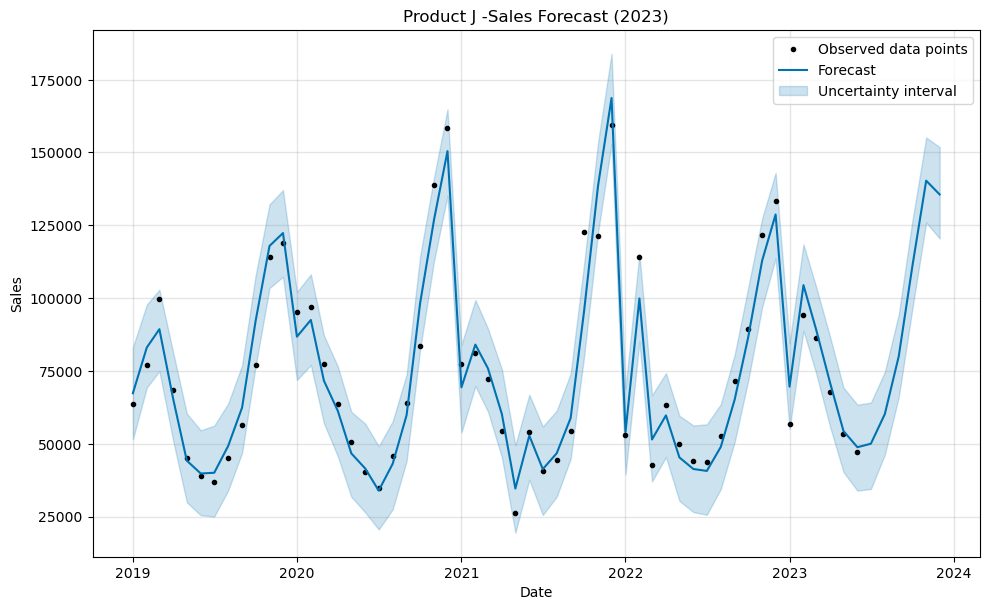

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product J -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

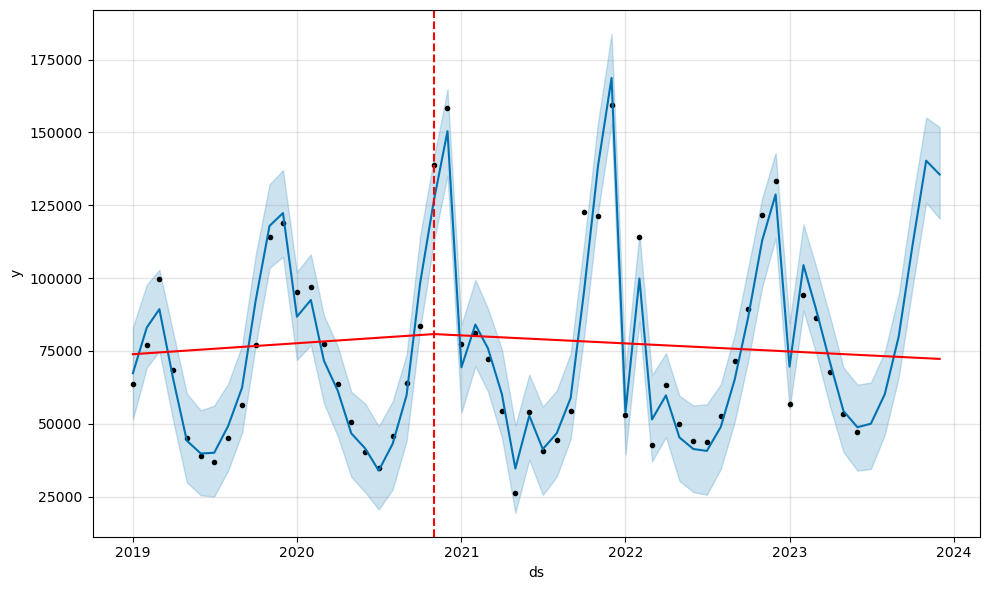

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

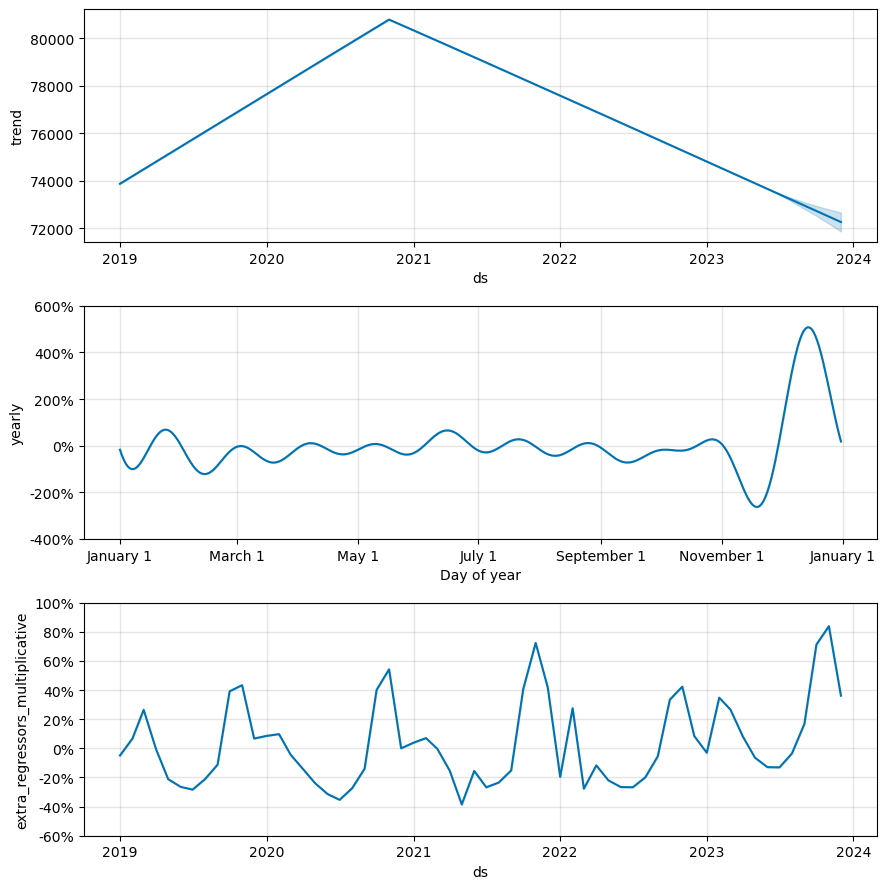

In [21]:
fig2 = model.plot_components(forecast)

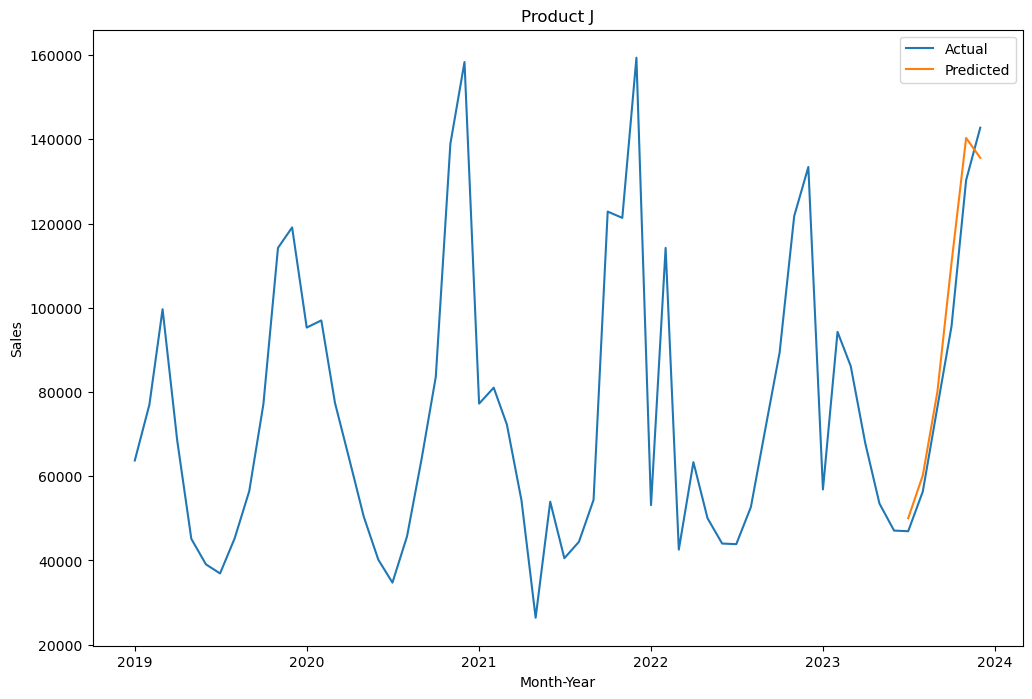

In [22]:
# Reset index of sales_b DataFrame
sales_j_reset_index = sales_j.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_j_reset_index['ds'], sales_j_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product J')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 7136.920
MAPE - FB PROPHET: 0.078
MSE - FB PROPHET: 69394015.793
RMSE - FB PROPHET: 8330.307


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,1.458045e+06,1207.495450,886.261311,0.016876,0.016876,0.017139,1.0
1,25 days,9.814048e+06,3132.738141,2897.470991,0.062676,0.062676,0.065217,1.0
2,29 days,2.196303e+08,14819.930688,12322.224889,0.227428,0.227428,0.202021,0.5
3,51 days,2.113792e+08,14538.884613,10509.253797,0.186020,0.186020,0.158360,0.5
4,55 days,8.971793e+08,29952.951755,21409.984642,0.190645,0.190645,0.232888,0.5
5,56 days,9.085382e+08,30141.967703,23573.031050,0.230904,0.230904,0.275286,0.5
6,60 days,2.369622e+08,15393.575642,13012.651183,0.158106,0.158106,0.148868,0.5
7,82 days,2.269207e+08,15063.885739,11462.209223,0.128161,0.128161,0.117002,0.5
8,83 days,6.851233e+07,8277.217553,6635.632526,0.151608,0.151608,0.135551,1.0
9,87 days,9.758568e+07,9878.546312,9696.695637,0.190781,0.190781,0.177645,1.0


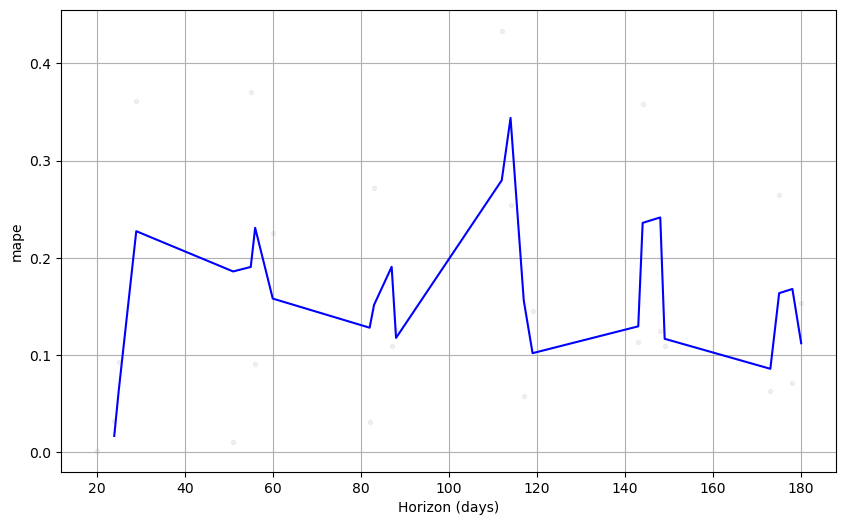

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

54     46924
55     56348
56     76393
57     95597
58    130293
59    142757
Name: y, dtype: int64

In [30]:
pred

54     50010.863065
55     60181.687117
56     80031.696330
57    110661.069426
58    140320.877329
59    135586.672819
Name: yhat, dtype: float64